# Fraud Detection Dataset Generation and Model Training

This notebook:
1. Generates synthetic fraud transaction data
2. Engineers features for fraud detection
3. Trains an IsolationForest anomaly detection model
4. Evaluates model performance
5. Saves model artifacts and processed data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style('whitegrid')

In [2]:
# Create necessary directories
import os
from pathlib import Path

# Get the project root directory (parent of notebooks/)
project_root = Path('..').resolve()

# Create directories if they don't exist
directories = [
    project_root / 'data' / 'raw',
    project_root / 'data' / 'processed',
    project_root / 'models'
]

for directory in directories:
    directory.mkdir(parents=True, exist_ok=True)
    print(f"✓ Directory ready: {directory}")

print("\nAll directories created successfully!")

✓ Directory ready: D:\Krishna Sai\AI-Agent-Capstone\data\raw
✓ Directory ready: D:\Krishna Sai\AI-Agent-Capstone\data\processed
✓ Directory ready: D:\Krishna Sai\AI-Agent-Capstone\models

All directories created successfully!


## 1. Generate Synthetic Transaction Data

In [3]:
def generate_synthetic_transactions(n_transactions=10000, fraud_ratio=0.05):
    """
    Generate synthetic financial transaction data with fraud labels.
    
    Features:
    - transaction_id: Unique identifier
    - customer_id: Customer identifier (500 unique customers)
    - timestamp: Transaction timestamp
    - amount: Transaction amount
    - merchant_id: Merchant identifier
    - merchant_category: Category of merchant
    - merchant_risk_category: Risk level of merchant
    - latitude: Transaction location latitude
    - longitude: Transaction location longitude
    - home_latitude: Customer home latitude
    - home_longitude: Customer home longitude
    - is_fraud: Fraud label (1 = fraud, 0 = legitimate)
    """
    
    n_fraud = int(n_transactions * fraud_ratio)
    n_legit = n_transactions - n_fraud
    
    # Generate customer IDs (500 unique customers)
    n_customers = 500
    customer_ids = np.random.randint(1000, 1000 + n_customers, n_transactions)
    
    # Generate timestamps (last 30 days)
    start_date = datetime.now() - timedelta(days=30)
    timestamps = [start_date + timedelta(
        days=np.random.randint(0, 30),
        hours=np.random.randint(0, 24),
        minutes=np.random.randint(0, 60)
    ) for _ in range(n_transactions)]
    
    # Merchant categories
    merchant_categories = ['retail', 'restaurant', 'grocery', 'gas', 'online', 
                          'entertainment', 'travel', 'gambling', 'crypto', 'high-risk-international']
    
    # Generate legitimate transactions
    legit_data = {
        'transaction_id': [f'TXN{i:08d}' for i in range(n_legit)],
        'customer_id': customer_ids[:n_legit],
        'timestamp': timestamps[:n_legit],
        'amount': np.abs(np.random.normal(150, 200, n_legit)).clip(1, 5000),
        'merchant_id': [f'MERCH{np.random.randint(1, 1000):05d}' for _ in range(n_legit)],
        'merchant_category': np.random.choice(merchant_categories[:7], n_legit, 
                                             p=[0.25, 0.20, 0.20, 0.15, 0.10, 0.05, 0.05]),
        'merchant_risk_category': np.random.choice(['low_risk', 'medium_risk'], n_legit, p=[0.8, 0.2]),
        # Legitimate transactions close to home (within 50km)
        'home_latitude': np.random.uniform(37.5, 38.0, n_legit),
        'home_longitude': np.random.uniform(-122.7, -122.1, n_legit),
        'is_fraud': 0
    }
    
    # Add small distance variation for legit transactions
    legit_data['latitude'] = legit_data['home_latitude'] + np.random.normal(0, 0.1, n_legit)
    legit_data['longitude'] = legit_data['home_longitude'] + np.random.normal(0, 0.1, n_legit)
    
    # Generate fraudulent transactions
    fraud_data = {
        'transaction_id': [f'TXN{i:08d}' for i in range(n_legit, n_transactions)],
        'customer_id': customer_ids[n_legit:],
        'timestamp': timestamps[n_legit:],
        # Fraud: higher amounts
        'amount': np.abs(np.random.normal(3000, 2000, n_fraud)).clip(1000, 20000),
        'merchant_id': [f'MERCH{np.random.randint(1, 1000):05d}' for _ in range(n_fraud)],
        # Fraud: riskier categories
        'merchant_category': np.random.choice(merchant_categories, n_fraud,
                                             p=[0.05, 0.05, 0.05, 0.05, 0.15, 0.05, 0.10, 0.20, 0.20, 0.10]),
        'merchant_risk_category': np.random.choice(['medium_risk', 'high_risk'], n_fraud, p=[0.3, 0.7]),
        'home_latitude': np.random.uniform(37.5, 38.0, n_fraud),
        'home_longitude': np.random.uniform(-122.7, -122.1, n_fraud),
        'is_fraud': 1
    }
    
    # Fraud: far from home (100+ km)
    fraud_data['latitude'] = fraud_data['home_latitude'] + np.random.uniform(-2, 2, n_fraud)
    fraud_data['longitude'] = fraud_data['home_longitude'] + np.random.uniform(-2, 2, n_fraud)
    
    # Combine and shuffle
    df_legit = pd.DataFrame(legit_data)
    df_fraud = pd.DataFrame(fraud_data)
    df = pd.concat([df_legit, df_fraud], ignore_index=True)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return df

# Generate dataset
print("Generating synthetic transaction data...")
df = generate_synthetic_transactions(n_transactions=10000, fraud_ratio=0.05)
print(f"Generated {len(df)} transactions")
print(f"Fraud cases: {df['is_fraud'].sum()} ({df['is_fraud'].mean()*100:.2f}%)")
print(f"Legitimate cases: {(1-df['is_fraud']).sum()} ({(1-df['is_fraud']).mean()*100:.2f}%)")
df.head()

Generating synthetic transaction data...
Generated 10000 transactions
Fraud cases: 500 (5.00%)
Legitimate cases: 9500 (95.00%)


,transaction_id,customer_id,timestamp,amount,merchant_id,merchant_category,merchant_risk_category,home_latitude,home_longitude,is_fraud,latitude,longitude
0,TXN00006252,1456,2025-11-25 17:08:50.729664,408.284824,MERCH00033,restaurant,low_risk,37.808472,-122.141870,0,37.790695,-122.239329
1,TXN00004684,1324,2025-11-10 06:58:50.729664,445.243304,MERCH00279,grocery,low_risk,37.990347,-122.115864,0,38.192598,-122.294326
2,TXN00001731,1399,2025-11-20 21:39:50.729664,197.994318,MERCH00407,online,medium_risk,37.659423,-122.589836,0,37.561380,-122.560215
3,TXN00004742,1499,2025-11-16 07:37:50.729664,28.817206,MERCH00549,retail,medium_risk,37.589507,-122.326744,0,37.584182,-122.269258
4,TXN00004521,1108,2025-11-14 08:41:50.729664,240.664100,MERCH00822,restaurant,medium_risk,37.953268,-122.177810,0,37.976479,-122.009772


## 2. Feature Engineering

In [4]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees).
    Returns distance in kilometers.
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

def engineer_features(df):
    """
    Engineer features for fraud detection:
    - hour: Hour of day (0-23)
    - day_of_week: Day of week (0-6)
    - is_weekend: Weekend flag
    - merchant_risk_score: Numeric risk score
    - geo_distance_km: Distance from home location
    - velocity_1h: Number of transactions in last 1 hour
    - amount_z_score: Z-score of transaction amount
    """
    df_feat = df.copy()
    
    # Time features
    df_feat['hour'] = pd.to_datetime(df_feat['timestamp']).dt.hour
    df_feat['day_of_week'] = pd.to_datetime(df_feat['timestamp']).dt.dayofweek
    df_feat['is_weekend'] = df_feat['day_of_week'].isin([5, 6]).astype(int)
    
    # Merchant risk score
    risk_mapping = {'low_risk': 0.0, 'medium_risk': 0.5, 'high_risk': 1.0}
    df_feat['merchant_risk_score'] = df_feat['merchant_risk_category'].map(risk_mapping)
    
    # Geo distance from home
    df_feat['geo_distance_km'] = haversine_distance(
        df_feat['home_latitude'].values,
        df_feat['home_longitude'].values,
        df_feat['latitude'].values,
        df_feat['longitude'].values
    )
    
    # Velocity (transactions per hour per customer)
    df_feat = df_feat.sort_values(['customer_id', 'timestamp'])
    df_feat['velocity_1h'] = 0
    
    for customer_id in df_feat['customer_id'].unique():
        customer_mask = df_feat['customer_id'] == customer_id
        customer_data = df_feat[customer_mask].copy()
        
        for idx in customer_data.index:
            current_time = customer_data.loc[idx, 'timestamp']
            time_window = current_time - timedelta(hours=1)
            count = ((customer_data['timestamp'] >= time_window) & 
                    (customer_data['timestamp'] < current_time)).sum()
            df_feat.loc[idx, 'velocity_1h'] = count
    
    # Amount z-score (per customer)
    df_feat['amount_mean'] = df_feat.groupby('customer_id')['amount'].transform('mean')
    df_feat['amount_std'] = df_feat.groupby('customer_id')['amount'].transform('std').fillna(1)
    df_feat['amount_z_score'] = (df_feat['amount'] - df_feat['amount_mean']) / df_feat['amount_std']
    
    return df_feat

print("Engineering features...")
df_features = engineer_features(df)
print("\nFeature columns:")
print(df_features.columns.tolist())
df_features.head()

Engineering features...

Feature columns:
['transaction_id', 'customer_id', 'timestamp', 'amount', 'merchant_id', 'merchant_category', 'merchant_risk_category', 'home_latitude', 'home_longitude', 'is_fraud', 'latitude', 'longitude', 'hour', 'day_of_week', 'is_weekend', 'merchant_risk_score', 'geo_distance_km', 'velocity_1h', 'amount_mean', 'amount_std', 'amount_z_score']


,transaction_id,customer_id,timestamp,amount,merchant_id,merchant_category,merchant_risk_category,home_latitude,home_longitude,is_fraud,...,longitude,hour,day_of_week,is_weekend,merchant_risk_score,geo_distance_km,velocity_1h,amount_mean,amount_std,amount_z_score
9786,TXN00008338,1000,2025-11-01 22:44:50.729664,135.946193,MERCH00424,travel,medium_risk,37.850648,-122.344432,0,...,-122.297166,22,5,1,0.5,19.388404,0,186.771907,125.755749,-0.404162
3206,TXN00009065,1000,2025-11-02 07:50:50.729664,42.310481,MERCH00917,restaurant,low_risk,37.708267,-122.452187,0,...,-122.448541,7,6,1,0.0,2.742041,0,186.771907,125.755749,-1.148746
5778,TXN00008805,1000,2025-11-02 14:46:50.729664,181.004373,MERCH00221,grocery,low_risk,37.510917,-122.370074,0,...,-122.348886,14,6,1,0.0,14.462093,0,186.771907,125.755749,-0.045863
4464,TXN00001397,1000,2025-11-04 05:37:50.729664,48.042431,MERCH00884,grocery,low_risk,37.563941,-122.363986,0,...,-122.431617,5,1,0,0.0,10.292575,0,186.771907,125.755749,-1.103166
9481,TXN00001167,1000,2025-11-05 11:49:50.729664,309.687366,MERCH00043,grocery,medium_risk,37.927466,-122.189954,0,...,-122.305399,11,2,0,0.5,10.366754,0,186.771907,125.755749,0.977414


## 3. Exploratory Data Analysis

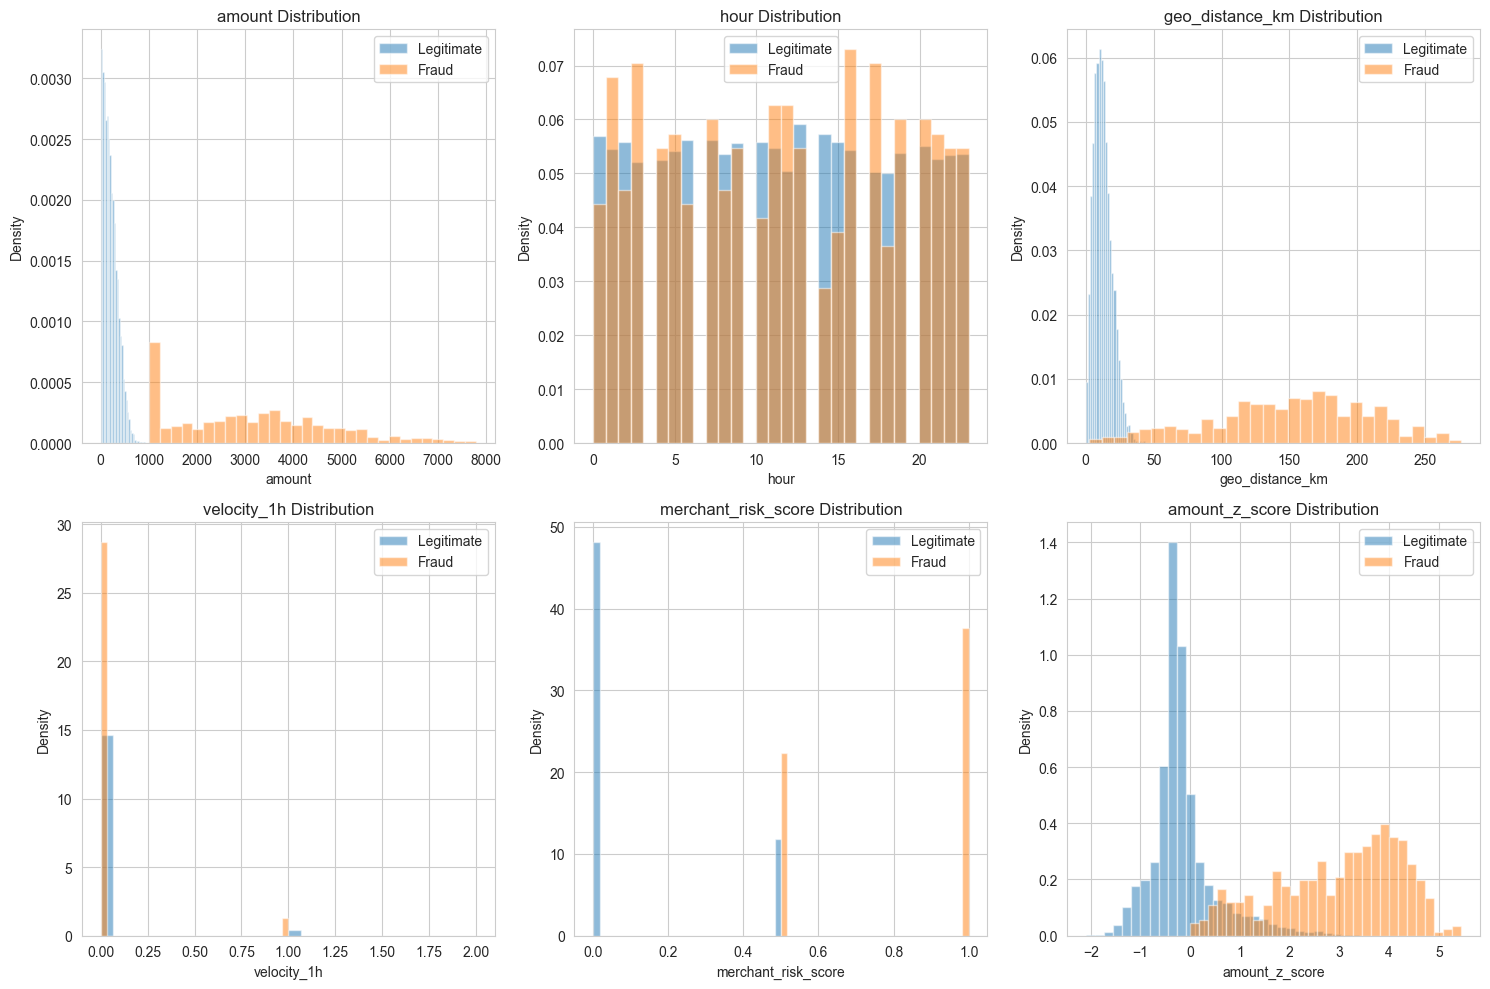


Feature Statistics by Fraud Label:
               amount       hour  geo_distance_km  velocity_1h  \
is_fraud                                                         
0          202.204893  11.425895        12.506404     0.026947   
1         3142.668330  11.520000       150.378315     0.042000   

          merchant_risk_score  amount_z_score  
is_fraud                                       
0                    0.098421       -0.157045  
1                    0.814000        2.983855  


In [5]:
# Distribution comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

features_to_plot = ['amount', 'hour', 'geo_distance_km', 'velocity_1h', 'merchant_risk_score', 'amount_z_score']

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    df_features[df_features['is_fraud'] == 0][feature].hist(ax=ax, bins=30, alpha=0.5, label='Legitimate', density=True)
    df_features[df_features['is_fraud'] == 1][feature].hist(ax=ax, bins=30, alpha=0.5, label='Fraud', density=True)
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()
    ax.set_title(f'{feature} Distribution')

plt.tight_layout()
plt.savefig('../data/processed/feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFeature Statistics by Fraud Label:")
print(df_features.groupby('is_fraud')[features_to_plot].mean())

## 4. Train IsolationForest Model

In [6]:
# Select features for model training
feature_columns = [
    'amount',
    'hour',
    'merchant_risk_score',
    'velocity_1h',
    'geo_distance_km',
    'amount_z_score',
    'is_weekend'
]

X = df_features[feature_columns].values
y = df_features['is_fraud'].values

# Split data and keep track of indices
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df_features.index, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Training fraud ratio: {y_train.mean()*100:.2f}%")
print(f"Test fraud ratio: {y_test.mean()*100:.2f}%")

Training set: 8000 samples
Test set: 2000 samples
Training fraud ratio: 5.00%
Test fraud ratio: 5.00%


In [7]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features standardized.")
print(f"Mean: {X_train_scaled.mean(axis=0)}")
print(f"Std: {X_train_scaled.std(axis=0)}")

Features standardized.
Mean: [ 2.22399182e-15  1.61703984e-16 -2.92738056e-16  2.39336329e-16
 -1.61679871e-15 -3.05918485e-17 -6.17478291e-16]
Std: [1. 1. 1. 1. 1. 1. 1.]


In [8]:
# Train IsolationForest
print("Training IsolationForest model...")

iso_forest = IsolationForest(
    contamination=0.05,  # Expected fraud ratio
    n_estimators=100,
    max_samples=256,
    random_state=42,
    n_jobs=-1
)

iso_forest.fit(X_train_scaled)

print("Model trained successfully!")
print(f"Number of trees: {iso_forest.n_estimators}")
print(f"Contamination: {iso_forest.contamination}")

Training IsolationForest model...
Model trained successfully!
Number of trees: 100
Contamination: 0.05


## 5. Model Evaluation

In [9]:
# Get anomaly scores (lower = more anomalous)
train_scores = iso_forest.score_samples(X_train_scaled)
test_scores = iso_forest.score_samples(X_test_scaled)

# Convert to fraud probability (0 to 1, higher = more likely fraud)
# Normalize using min-max scaling and invert
def scores_to_probabilities(scores):
    # Invert (more negative = higher fraud probability)
    inverted = -scores
    # Normalize to [0, 1]
    min_score = inverted.min()
    max_score = inverted.max()
    probs = (inverted - min_score) / (max_score - min_score)
    return probs

train_probs = scores_to_probabilities(train_scores)
test_probs = scores_to_probabilities(test_scores)

# Calculate AUC
train_auc = roc_auc_score(y_train, train_probs)
test_auc = roc_auc_score(y_test, test_probs)

print(f"Training AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Training AUC: 0.9993
Test AUC: 0.9987


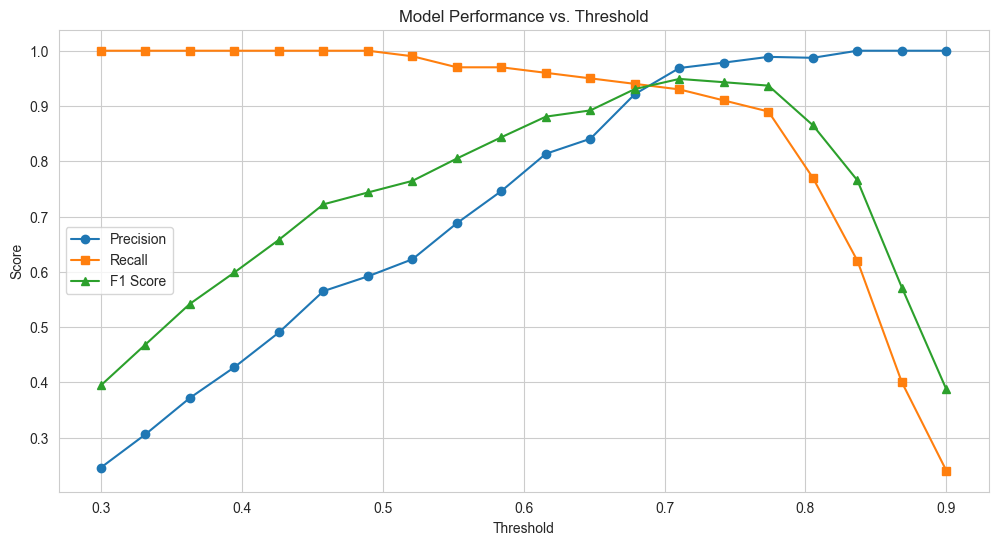


Best F1 threshold: 0.711
Precision: 0.969
Recall: 0.930
F1: 0.949


In [10]:
# Threshold analysis
thresholds = np.linspace(0.3, 0.9, 20)
metrics = []

for threshold in thresholds:
    y_pred = (test_probs >= threshold).astype(int)
    
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    metrics.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

metrics_df = pd.DataFrame(metrics)

# Plot metrics vs threshold
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['threshold'], metrics_df['precision'], label='Precision', marker='o')
plt.plot(metrics_df['threshold'], metrics_df['recall'], label='Recall', marker='s')
plt.plot(metrics_df['threshold'], metrics_df['f1'], label='F1 Score', marker='^')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Model Performance vs. Threshold')
plt.legend()
plt.grid(True)
plt.savefig('../data/processed/threshold_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Find best F1 threshold
best_f1_idx = metrics_df['f1'].idxmax()
best_threshold = metrics_df.loc[best_f1_idx, 'threshold']
print(f"\nBest F1 threshold: {best_threshold:.3f}")
print(f"Precision: {metrics_df.loc[best_f1_idx, 'precision']:.3f}")
print(f"Recall: {metrics_df.loc[best_f1_idx, 'recall']:.3f}")
print(f"F1: {metrics_df.loc[best_f1_idx, 'f1']:.3f}")

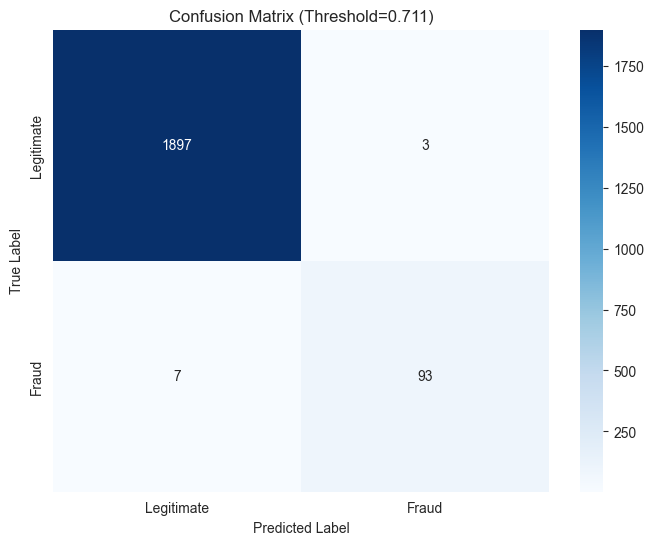


Confusion Matrix:
True Negatives: 1897
False Positives: 3
False Negatives: 7
True Positives: 93


In [11]:
# Confusion matrix at best threshold
y_pred_best = (test_probs >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'Confusion Matrix (Threshold={best_threshold:.3f})')
plt.savefig('../data/processed/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConfusion Matrix:")
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

## 6. Feature Importance (Approximation)


Feature Importance:
               feature  importance
0               amount    0.340755
5       amount_z_score    0.306175
4      geo_distance_km    0.185224
2  merchant_risk_score    0.161876
6           is_weekend    0.004258
3          velocity_1h    0.001151
1                 hour    0.000562


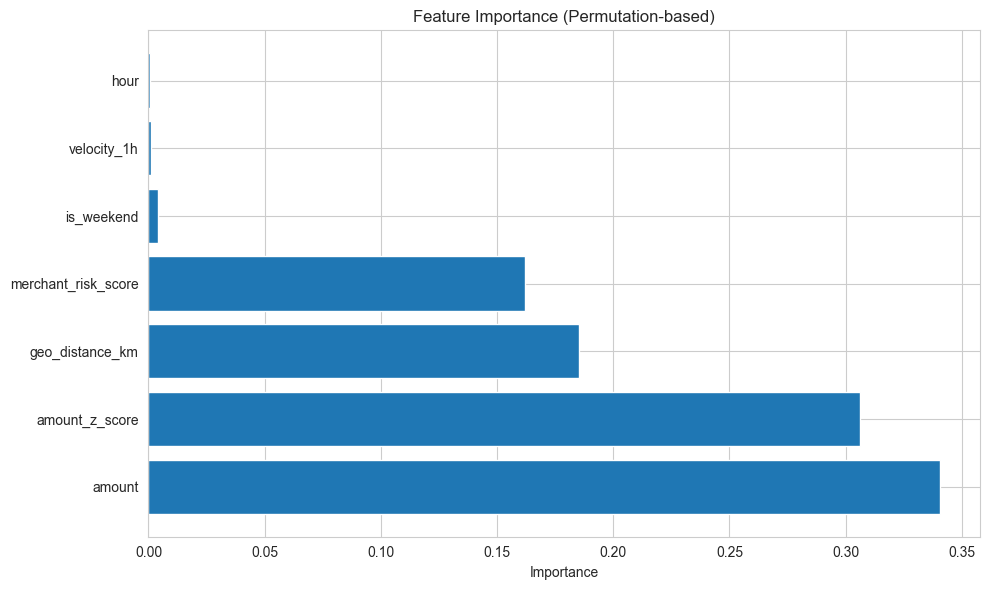

In [12]:
# Approximate feature importance by measuring score change when shuffling each feature
def get_feature_importance(model, X, feature_names):
    """
    Approximate feature importance by permutation.
    """
    baseline_score = model.score_samples(X).mean()
    importances = []
    
    for i in range(X.shape[1]):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, i])
        permuted_score = model.score_samples(X_permuted).mean()
        importance = abs(baseline_score - permuted_score)
        importances.append(importance)
    
    # Normalize
    importances = np.array(importances)
    importances = importances / importances.sum()
    
    return pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

feature_importance = get_feature_importance(iso_forest, X_test_scaled, feature_columns)
print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (Permutation-based)')
plt.tight_layout()
plt.savefig('../data/processed/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Save Model Artifacts and Data

In [13]:
# Save model and scaler
print("Saving model artifacts...")

joblib.dump(iso_forest, '../models/iso_fraud.pkl')
joblib.dump(scaler, '../models/scaler.pkl')

# Save feature names
with open('../models/feature_columns.json', 'w') as f:
    json.dump(feature_columns, f, indent=2)

# Save best threshold
with open('../models/model_config.json', 'w') as f:
    json.dump({
        'best_threshold': float(best_threshold),
        'train_auc': float(train_auc),
        'test_auc': float(test_auc),
        'feature_columns': feature_columns,
        'contamination': 0.05,
        'n_estimators': 100
    }, f, indent=2)

print("Model artifacts saved to ../models/")

Saving model artifacts...
Model artifacts saved to ../models/


In [14]:
# Save processed data
print("Saving processed data...")

# Add model scores to dataframe using the correct indices
df_features['ml_fraud_score'] = np.nan
df_features.loc[idx_test, 'ml_fraud_score'] = test_probs

# Save full dataset
df_features.to_csv('../data/processed/transactions_enriched.csv', index=False)
print("Saved to ../data/processed/transactions_enriched.csv")

# Save test set with predictions
df_test = df_features.loc[idx_test].copy()
df_test['ml_fraud_prediction'] = y_pred_best
df_test.to_csv('../data/processed/test_set_with_predictions.csv', index=False)
print("Saved test set to ../data/processed/test_set_with_predictions.csv")

# Save as JSON for agent use
sample_transactions = df_test.head(100).to_dict('records')
with open('../data/processed/sample_transactions.json', 'w') as f:
    json.dump(sample_transactions, f, indent=2, default=str)
print("Saved sample to ../data/processed/sample_transactions.json")

Saving processed data...
Saved to ../data/processed/transactions_enriched.csv
Saved test set to ../data/processed/test_set_with_predictions.csv
Saved sample to ../data/processed/sample_transactions.json


## 8. Summary

In [15]:
print("="*60)
print("FRAUD DETECTION MODEL TRAINING SUMMARY")
print("="*60)
print(f"\nDataset:")
print(f"  Total transactions: {len(df_features)}")
print(f"  Fraud ratio: {df_features['is_fraud'].mean()*100:.2f}%")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"\nModel:")
print(f"  Type: IsolationForest")
print(f"  Number of estimators: 100")
print(f"  Contamination: 0.05")
print(f"\nPerformance:")
print(f"  Training AUC: {train_auc:.4f}")
print(f"  Test AUC: {test_auc:.4f}")
print(f"  Best threshold: {best_threshold:.3f}")
print(f"  Precision @ best: {metrics_df.loc[best_f1_idx, 'precision']:.3f}")
print(f"  Recall @ best: {metrics_df.loc[best_f1_idx, 'recall']:.3f}")
print(f"  F1 @ best: {metrics_df.loc[best_f1_idx, 'f1']:.3f}")
print(f"\nFeatures:")
for feat in feature_columns:
    print(f"  - {feat}")
print(f"\nArtifacts saved:")
print(f"  - ../models/iso_fraud.pkl")
print(f"  - ../models/scaler.pkl")
print(f"  - ../models/feature_columns.json")
print(f"  - ../models/model_config.json")
print(f"  - ../data/processed/transactions_enriched.csv")
print(f"  - ../data/processed/test_set_with_predictions.csv")
print(f"  - ../data/processed/sample_transactions.json")
print("="*60)

FRAUD DETECTION MODEL TRAINING SUMMARY

Dataset:
  Total transactions: 10000
  Fraud ratio: 5.00%
  Training samples: 8000
  Test samples: 2000

Model:
  Type: IsolationForest
  Number of estimators: 100
  Contamination: 0.05

Performance:
  Training AUC: 0.9993
  Test AUC: 0.9987
  Best threshold: 0.711
  Precision @ best: 0.969
  Recall @ best: 0.930
  F1 @ best: 0.949

Features:
  - amount
  - hour
  - merchant_risk_score
  - velocity_1h
  - geo_distance_km
  - amount_z_score
  - is_weekend

Artifacts saved:
  - ../models/iso_fraud.pkl
  - ../models/scaler.pkl
  - ../models/feature_columns.json
  - ../models/model_config.json
  - ../data/processed/transactions_enriched.csv
  - ../data/processed/test_set_with_predictions.csv
  - ../data/processed/sample_transactions.json
